## 导包

In [4]:
import torch
import torch.nn as nn
from collections import OrderedDict
import numpy as np
# %matplotlib widget
from matplotlib import pyplot as plt
from numpy import matrix as mat
from torch.nn.modules import loss
from functorch import make_functional, vmap, grad, jacrev, hessian
import jax
import time
from matplotlib.ticker import FuncFormatter
pi=np.pi

## 模型

In [5]:
class Network(nn.Module):
    def __init__(
        self,
        input_size, # 输入层神经元数
        hidden_size, # 隐藏层神经元数
        output_size, # 输出层神经元数
        depth, # 隐藏层数
        act=torch.nn.Tanh(), # 输入层和隐藏层的激活函数
    ):
        super(Network, self).__init__()

        # 输入层
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        #self.relu = nn.ReLU() torch.nn.Tanh()
        self.tanh = act
        # 隐藏层
        self.layer2 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.layer3 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        #self.relu = nn.ReLU()
        self.tanh = act
        # 输出层
        self.layer4 = nn.Linear(in_features=hidden_size, out_features=output_size,bias=False)



    def forward(self, x):
        x = self.layer1(x)
        #x = self.relu(x)
        x= self.tanh(x)
        x = self.layer2(x)
        #x = self.relu(x)
        x = self.tanh(x)
        x = self.layer3(x)
        x = self.tanh(x)
        x = self.layer4(x)

        return x
    

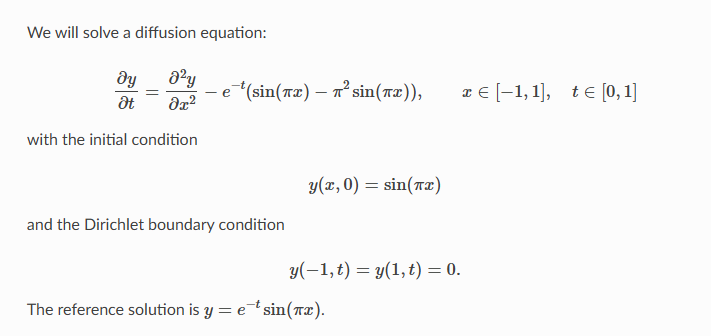

In [21]:
"""PINN_S"""
class PINN_S:
    def __init__(self):
        self.input_size = 2
        self.hidden_size =20
        self.output_size = 1
        self.depth = 1
        global device
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")  # 选择使用GPU还是CPU
        self.model = Network(self.input_size, self.hidden_size,  self.output_size, self.depth, act=  torch.nn.Tanh() ).double().to(device)  # 定义神经网络
        self.p_number = self.input_size * self.hidden_size + self.hidden_size + (self.hidden_size * self.hidden_size + self.hidden_size)*2 +self.hidden_size * self.output_size  # 参数的个数
        print('model # of parameters',self.p_number)
        
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)


        # 定义迭代序号，记录调用了多少次loss
        self.iter = 1000
        self.loss_record=np.zeros(10000)
        self.loss_iter=0
        self.Sampledata=np.array([])


        
    
    def new_sampling(self,i):
            """
            i - random seed 
            points_num - # of points inside 
            """
            # 指定区间
            torch.set_default_dtype(torch.float64)
            lower_boundx = -1
            upper_boundx = 1
            lower_boundy=0
            upper_boundy=1
            random_samples = 7
            torch.manual_seed(1+i)
            x = (upper_boundx - lower_boundx) * torch.rand(random_samples) + lower_boundx 
            torch.manual_seed(2+i)
            y = (upper_boundy - lower_boundy) * torch.rand(random_samples) + lower_boundy  
            self.X_inside = torch.stack(torch.meshgrid(x, y)).reshape(2, -1).T  
            self.X_inside=self.X_inside.to(device)
            self.X_inside.requires_grad = True
            self.X_inside_num=self.X_inside.size(0) 
            
            random_samples = 10
            torch.manual_seed(3+i)
            x = (upper_boundx - lower_boundx) * torch.rand(random_samples) + lower_boundx 
            torch.manual_seed(4+i)
            y = (upper_boundy - lower_boundy) * torch.rand(random_samples) + lower_boundy 
            bc1 = torch.stack(torch.meshgrid(torch.tensor(lower_boundx).double(), y)).reshape(2, -1).T  # x=-1边界
            bc2 = torch.stack(torch.meshgrid(torch.tensor(upper_boundx).double(), y)).reshape(2, -1).T  # x=+1边界
            random_samples=10
            x = (upper_boundx - lower_boundx) * torch.rand(random_samples) + lower_boundx 
            bc3 = torch.stack(torch.meshgrid(x, torch.tensor(lower_boundy).double())).reshape(2, -1).T # y=0边界

            self.X_boundary = torch.cat([bc1, bc2, bc3])  # 将所有边界处的时空坐标点整合为一个张量
            self.X_boundary1=torch.cat([bc1, bc2])
            self.X_boundary2=bc3

            
            self.X_boundary_num1=self.X_boundary1.size(0)
            self.X_boundary_num2=self.X_boundary2.size(0)
            self.X_boundary_num=self.X_boundary_num1+self.X_boundary_num2
            self.X_inside_num=self.X_inside.size(0)

        
            self.X_boundary=self.X_boundary.to(device)
            self.X_boundary1=self.X_boundary1.to(device)
            self.X_boundary2=self.X_boundary2.to(device)
            self.X_inside=self.X_inside.to(device)

            self.X_boundary.requires_grad = True
            self.X_boundary1.requires_grad = True
            self.X_boundary2.requires_grad = True

            self.X_boundary=self.X_boundary.double()
            self.X_boundary1=self.X_boundary1.double()
            self.X_boundary2=self.X_boundary2.double()
            self.X_inside=self.X_inside.double()

    
    def LM(self,opt_num, step,deterministic=True,mu=1):
        """ 
        Parameters:
        opt_num -  优化的参数数量 
        step: LM 下降的次数 
        deterministic: 是否要严格下降 True 为是
        mu: 1 为LM method， 0 为Gauss-Newton => deterministic=False
        需要修改的部分：fx_fun 函数; J_func 函数; 
        """

        if mu==0:
            deterministic=False
        p_number = self.p_number
        params = torch.cat([p.view(-1) for p in self.model.parameters()], dim=0).to(device) # 把模型参数展平成一维向量

        
    
        def f(params, input_data):
            
            with torch.no_grad():
                a = self.hidden_size * self.input_size
                self.model.layer1.weight.data = params[:a].reshape(self.hidden_size, self.input_size).clone()  # layer1的权重
                self.model.layer1.bias.data = params[a:a + self.hidden_size].clone()  # layer1的偏置
                a += self.hidden_size
                self.model.layer2.weight.data = params[a:a + self.hidden_size * self.hidden_size].reshape(self.hidden_size, self.hidden_size).clone()  # layer2的权重
                a += self.hidden_size * self.hidden_size
                self.model.layer2.bias.data = params[a:a + self.hidden_size].clone()  # layer2的偏置
                a += self.hidden_size
                self.model.layer3.weight.data = params[a:a + self.hidden_size * self.hidden_size].reshape(self.hidden_size, self.hidden_size).clone()  # layer2的权重
                a += self.hidden_size * self.hidden_size
                self.model.layer3.bias.data = params[a:a + self.hidden_size].clone()  # layer2的偏置
                a += self.hidden_size
                self.model.layer4.weight.data = params[a:a + self.output_size * self.hidden_size].reshape(self.output_size, self.hidden_size).clone()  # layer3的权重
                a += self.output_size * self.hidden_size
                # self.model.layer3.bias.data = params[a].clone()  # layer3的偏置
            
            model_output=torch.vmap(self.model)(input_data)    
            
            return model_output
        
        def fx_fun(params)->np.array:
            
            f_inside = f(params, self.X_inside)  # 使用当前模型计算内点处的预测值
            f_inside.require_grad = True
            du_dX = torch.autograd.grad(
                inputs=self.X_inside,
                outputs=f_inside,
                grad_outputs=torch.ones_like(f_inside),
                retain_graph=True,
                create_graph=True
                )[0][:,0]  # 使用自动求导方法得到U对X的导数
            du_dY = torch.autograd.grad(
                inputs=self.X_inside,
                outputs=f_inside,
                grad_outputs=torch.ones_like(f_inside),
                retain_graph=True,
                create_graph=True
            )[0][:,1]  # 使用自动求导方法得到U对X的导数
            # 使用自动求导方法得到U对X的二阶导数
            du_dxx = torch.autograd.grad(
                inputs=self.X_inside,
                outputs=du_dX,
                grad_outputs=torch.ones_like(du_dX),
                retain_graph=True,
                create_graph=True
            )[0][:, 0]
            
            
            # fx = torch.zeros(self.X_inside_num)
            # for i in range(self.X_inside_num):  # 数据点的数量
            #     fx[i] = du_dY[i]+f_inside[i]*du_dX[i]-(0.01/torch.pi)*du_dxx[i]
            fx = du_dY-du_dxx + torch.exp(-self.X_inside[:,1])*(torch.sin(pi*self.X_inside[:,0])-(pi**2)*torch.sin(pi*self.X_inside[:,0]))
            fx=fx.to(device)
            fx=fx.view(-1)
            
            f_bd = f(params, self.X_boundary1)
            
            fx_bd = f_bd.view(-1)
            # for i in range(self.X_boundary_num1):  # 数据点的数量
            #     fx_bd[i] = f_bd[i]
            

            fx = torch.cat((fx, fx_bd), dim=0)

            f_ini=f(params, self.X_boundary2)
            f_ini=f_ini.view(-1)
            # for i in range(self.X_boundary_num2):  # 数据点的数量
            #     fx_ini[i] = f_ini[i]+torch.sin(torch.pi*self.X_boundary2[i,0])
            fx_ini = f_ini-torch.sin(torch.pi*self.X_boundary2[:,0])
            
            fx = torch.cat((fx, fx_ini), dim=0)
            fx=fx.t()
            return fx

        def F_fun(fx):
            F_p = 0
            for i in range(self.X_inside_num+self.X_boundary_num):
                F_p += (fx[i]) ** 2  # F_p.shape是tensor.size([1])
            F_p /= (self.X_inside_num+self.X_boundary_num)
            return F_p
        

        def J_func(params):
            J = torch.zeros(self.X_inside_num+self.X_boundary_num, p_number).to(device)
            
            params.requires_grad_(True)
            def Inter(params, input):
                
                f_inside = f(params, input)  # 使用当前模型计算内点处的预测值
                
                func_model, func_params = make_functional(self.model)
                def fm(x, func_params):
                    fx = func_model(func_params, x)
                    return fx.squeeze(0).squeeze(0)
                def floss(func_params,input):
                    f_inside=fm(input, func_params) 
                    d1u = jacrev((fm))(input, func_params)            
                    d2u = jacrev(jacrev(fm))(input,func_params)
                    
                    du_dY=d1u[1]    
                    du_dX=d1u[0]    
                    du_dxx=d2u[0][0]     
                    
                    fx = du_dY-du_dxx + torch.exp(-input[1])*(torch.sin(pi*input[0])-(pi**2)*torch.sin(pi*input[0]))
                    # print('du_dY',du_dY)
                    return fx
                    
                
                per_sample_grads =vmap(jacrev(floss), (None, 0))(func_params, input)
                
                cnt=0
                
                for g in per_sample_grads: 
                    g = g.detach()
                    J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
                    cnt = 1
                
                result= J_d.detach()
                

                return result
            
            def Bound(params,input):
                f_bound=f(params,input)
                
                func_model, func_params = make_functional(self.model)
                def fm(x, func_params):
                    fx = func_model(func_params, x)
                    return fx.squeeze(0).squeeze(0)
                def floss(func_params,input):
                    fx = fm(input, func_params)

                    return fx
                
                per_sample_grads =vmap(jacrev(floss), (None, 0))(func_params, input)
                
                cnt=0
                for g in per_sample_grads: 
                    g = g.detach()
                    J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
                    cnt = 1
                
                result = J_d.detach()
                
                return result
            
            def INIC(params,input):
                f_bound=f(params,input)
                
                def SINP(x):
                    return torch.sin(torch.pi*x)
                func_model, func_params = make_functional(self.model)
                def fm(x, func_params):
                    fx = func_model(func_params, x)
                    return fx.squeeze(0).squeeze(0)
                def floss(func_params,input):           
                    fx = fm(input, func_params)-torch.sin(torch.pi*input[0])
                    return fx
                
                per_sample_grads =vmap(jacrev(floss), (None, 0))(func_params, input)
                
                cnt=0
                for g in per_sample_grads: 
                    g = g.detach()
                    J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
                    cnt = 1
                
                result= J_d.detach()
                

                return result
            
            J[range(self.X_inside_num), :] = Inter(params, self.X_inside)
            J[range(self.X_inside_num, self.X_inside_num + self.X_boundary_num1), :] = Bound(params, self.X_boundary1)
            J[range(self.X_inside_num + self.X_boundary_num1, self.X_inside_num + self.X_boundary_num1+self.X_boundary_num2), :] = INIC(params, self.X_boundary2)
            # print('Jacobian matrix',J)
            
            return J
        
        #######################################
        #参数准备
        k = 0
        kmax = step
        p = params.to(device)
        J = J_func(p)
        A = torch.matmul(J.t(),J)
        F_p = torch.tensor(10).to(device)
        F_pnew = 0
        alpha = 1
        lambda_up = 10
        lambda_down = 0.1
        diag = torch.eye(p_number)

        ##########################

        ####随机选择部分参数进行优化
        
        selected_columns = np.random.choice(p_number, opt_num, replace=False)
        ####
        if deterministic:
            while (k < kmax):  # (not found)
                k = k + 1
                print("step = ", k)
                J_opt=J[:,selected_columns]
                A_opt= torch.matmul(J_opt.t(),J_opt)
                diag=torch.eye(A_opt.shape[0]).to(device)
                H = A_opt + mu * diag
                
                fx = fx_fun(p)
                
                try:              
                    h_lm = torch.linalg.solve(-H, torch.matmul(J_opt.t(),fx))             
                except:
                    eigenvalues, eigenvectors = torch.linalg.eig(-H)
                    # 输出特征值和特征向量
                    print("特征值：", eigenvalues)
                    print("特征向量：\n", eigenvectors)
                    print('singular matrix ')
                    break
                
                # print("h_lm=",h_lm)
                if (torch.abs(F_p - F_pnew)/torch.max(F_p,F_pnew) < 1e-7):  # tol_para = 0.000001
                    print('converge in para updates')
                    break
                else:
                    
                    p_new=p.clone()
                    p_new[selected_columns]+= alpha * torch.squeeze(h_lm)
                    
                    
                    F_p = F_fun(fx)
                    print("Loss =", F_p.item())
                    fx_new = fx_fun(p_new)
                    F_pnew = F_fun(fx_new)
                    print("Loss new=", F_pnew.item())
                    
                    o = F_p - F_pnew
                    if o > 0:
                        self.loss_record[self.loss_iter] = float(F_pnew.item())
                        self.loss_iter += 1
                        print('move')
                        p = p_new
                        J = J_func(p)  # update J
                    
                        mu = mu * lambda_down  # lower limit u =1e-11
                       
                        
                    else:
                        print('reject move')
                        mu = mu * lambda_up  # Up limit u =1e11
                
        else:
            pass
                    
                        
        return p
    
    
    def plt(self):
        pass

    def error(self):
        pass
    

## 选择参数训练 


In [22]:
# seed 从7开始 训练的 记得改保存路径
torch.cuda.empty_cache() 
pinns_all=PINN_S()
for i in range(10):
    pinns_all.new_sampling(9+i)
    pinns_all.LM(920,100,True)

# np.save("losspinnsall_record99.npy", pinns_all.loss_record)

model # of parameters 920
step =  1
Loss = tensor(8.1533, device='cuda:0', grad_fn=<DivBackward0>)
Loss new= tensor(1522.2031, device='cuda:0', grad_fn=<DivBackward0>)
reject move
step =  2
Loss = tensor(8.1533, device='cuda:0', grad_fn=<DivBackward0>)
Loss new= tensor(286.4425, device='cuda:0', grad_fn=<DivBackward0>)
reject move
step =  3
Loss = tensor(8.1533, device='cuda:0', grad_fn=<DivBackward0>)
Loss new= tensor(3.2803, device='cuda:0', grad_fn=<DivBackward0>)
nice move
step =  4
Loss = tensor(3.2803, device='cuda:0', grad_fn=<DivBackward0>)
Loss new= tensor(5.6035, device='cuda:0', grad_fn=<DivBackward0>)
reject move
step =  5
Loss = tensor(3.2803, device='cuda:0', grad_fn=<DivBackward0>)
Loss new= tensor(1.0813, device='cuda:0', grad_fn=<DivBackward0>)
nice move
step =  6
Loss = tensor(1.0813, device='cuda:0', grad_fn=<DivBackward0>)
Loss new= tensor(0.3694, device='cuda:0', grad_fn=<DivBackward0>)
nice move
step =  7
Loss = tensor(0.3694, device='cuda:0', grad_fn=<DivBackward

In [116]:
torch.cuda.empty_cache() 
pinns_ran=PINN_S()
for i in range(10):
    pinns_ran.new_sampling(9+i)
    pinns_ran.LM(400,100,True)

model # of parameters 920
step =  1
Loss = [[8.15331187]]
Loss new= [[397.51661464]]
reject move
step =  2
Loss = [[8.15331187]]
Loss new= [[51.41329562]]
reject move
step =  3
Loss = [[8.15331187]]
Loss new= [[1.7832365]]
nice move


f:\Anaconda3\envs\my-env\Lib\site-packages\torch\_functorch\deprecated.py:100: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
f:\Anaconda3\envs\my-env\Lib\site-packages\torch\_functorch\deprecated.py:83: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html


step =  4
Loss = [[1.7832365]]
Loss new= [[0.83495484]]
nice move
step =  5
Loss = [[0.83495484]]
Loss new= [[1.93606228]]
reject move
step =  6
Loss = [[0.83495484]]
Loss new= [[0.32077157]]
nice move
step =  7
Loss = [[0.32077157]]
Loss new= [[0.30489002]]
nice move
step =  8
Loss = [[0.30489002]]
Loss new= [[1.32997648]]
reject move
step =  9
Loss = [[0.30489002]]
Loss new= [[0.66364983]]
reject move
step =  10
Loss = [[0.30489002]]
Loss new= [[0.07941734]]
nice move
step =  11
Loss = [[0.07941734]]
Loss new= [[0.11696194]]
reject move
step =  12
Loss = [[0.07941734]]
Loss new= [[0.02201732]]
nice move
step =  13
Loss = [[0.02201732]]
Loss new= [[0.02339463]]
reject move
step =  14
Loss = [[0.02201732]]
Loss new= [[0.0139026]]
nice move
step =  15
Loss = [[0.0139026]]
Loss new= [[0.01016132]]
nice move
step =  16
Loss = [[0.01016132]]
Loss new= [[0.10157256]]
reject move
step =  17
Loss = [[0.01016132]]
Loss new= [[0.00430379]]
nice move
step =  18
Loss = [[0.00430379]]
Loss new= [[

error 0.11655360842088987


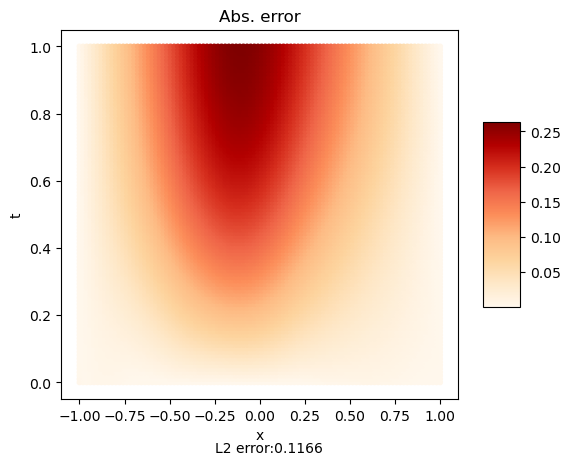

In [120]:
x = np.linspace(-1, 1, 100)
y = np.linspace(0, 1, 100)
xx, tt = np.meshgrid(x, y)
X = torch.DoubleTensor(np.stack([xx.ravel(), tt.ravel()], axis=1)).to(device)
y = (torch.exp(-X[:,1])*torch.sin(pi*X[:,0])).flatten()[:, None].cpu()
# 计算模型的输出
with torch.no_grad():
    y=y-pinns_all.model(X).cpu().numpy()
# 将输出重塑为网格的形状以便于绘图
Z = np.abs(y.reshape(xx.shape))

# 绘制三维图

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
surf = ax.scatter(xx, tt, c=Z, cmap='OrRd', s = 10)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Abs. error')
#ax.axis('equal')



outputs = np.abs(y.numpy())
error=np.sqrt(np.sum(outputs**2))/np.sqrt(len(y))
print('error',error)
error = "{:.4f}".format(error)
plt.figtext(0.45, 0, f"L2 error:{error}", ha='center', fontsize=10)
plt.show()

### Loss 对照图

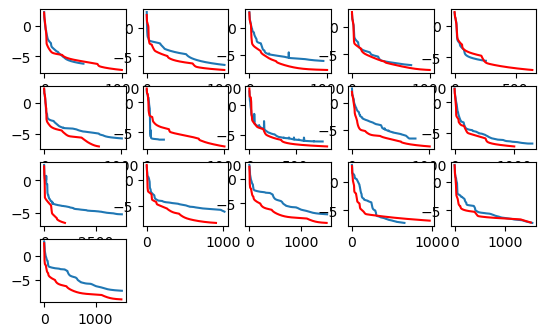

In [29]:
import numpy as np
import matplotlib.pyplot as plt

figure = plt.figure()

# 循环处理每个子图和数据文件
for i in range(1, 17):
    ax = figure.add_subplot(5, 5, i)
    
    # 加载并处理第i个数据文件
    loss = np.load(f"losspinns_record{i}.npy")
    loss = np.log10(loss[loss != 0])
    ax.plot(loss)
    
    loss_all = np.load(f"losspinnsall_record{i}.npy")
    loss_all = np.log10(loss_all[loss_all != 0])
    ax.plot(loss_all, 'r')

plt.show()

[-0.67496765  0.24795318  0.85963356 -0.48821199  0.95914471 -0.98820555
  0.34819841  0.26762354 -0.30683529 -0.3143611  -0.78255737 -0.2005043
 -0.37220573 -0.24271798  0.83048916  0.30142903 -0.99366975 -0.59712005
  0.79756021 -0.01292038 -0.39513385  0.56344974  0.93207669 -0.70356345
  0.99194193 -0.26541734  0.12751353 -0.80612791 -0.85597229 -0.74840105
 -0.73452425 -0.97256136 -0.33531356  0.10588777  0.70321417  0.43546903
 -0.88818264  0.77184701 -0.22495592 -0.98312652  0.88991976 -0.74192607
  0.85574818  0.64308786 -0.97947705 -0.38862848  0.67389083  0.07001173
  0.05800998 -0.52924466 -0.87354338 -0.73465168  0.25179756 -0.84767663
 -0.84625065  0.70400786 -0.19850373  0.98331165 -0.29023218 -0.03433037
 -0.02265286  0.77672672  0.77450812 -0.03909087  0.28926325  0.39168465
 -0.26748133 -0.5312326  -0.00431049  0.95377636  0.61402643 -0.58512986
 -0.53762329 -0.50373065  0.26291442  0.29708803 -0.1753031  -0.74020314
  0.87721455  0.48642111 -0.09724414  0.43654668  0.

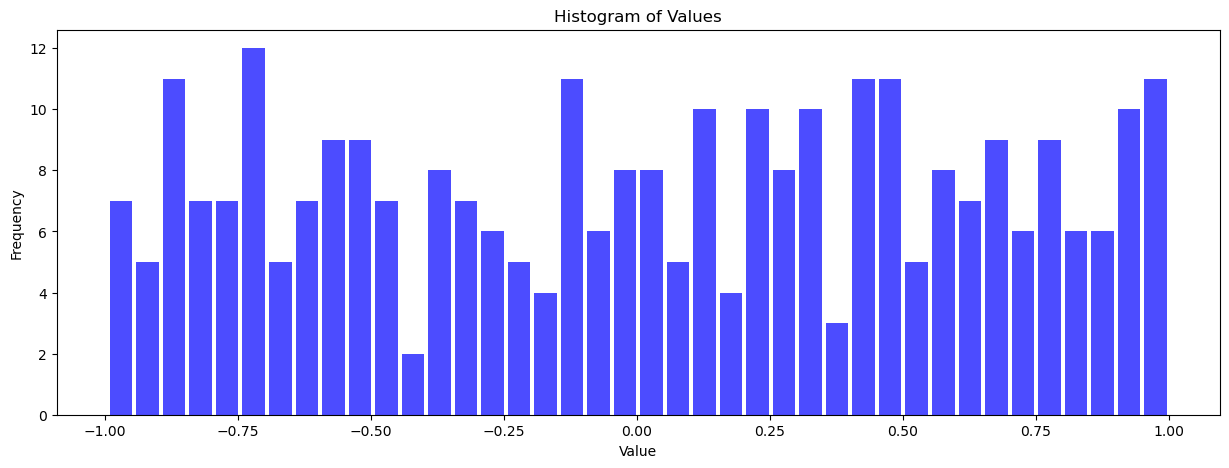

In [64]:
array = pinns.Sampledata.flatten()
print(array)
# 创建一个新的图形用于绘制直方图
fig, ax = plt.subplots(figsize=(15, 5))

# 绘制直方图以显示点的分布
ax.hist(array, bins=40, color='blue', alpha=0.7, rwidth=0.85)

# 设置轴标签
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')

# 设置标题
ax.set_title('Histogram of Values')

# 显示图形
plt.show()